### dependencies & global variables


In [42]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

### Building.txt data - 2018 Ztrax


In [43]:
# read in data
building_df = pd.read_csv(
    '../../8_AltData/2018_Ztrax/Building.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    3: 'landUse_desc',
    5: 'landUse_code',
    8: 'building_no',
    45: 'FIPS'
}

# Rename and select the relevant columns fromt the above dictionary
building_df = building_df.rename(columns=rename_dict)[
    list(rename_dict.values())]

# cast FIPS as string
building_df['FIPS'] = building_df['FIPS'].astype(str)

# define list of metro ATL counties
atl_FIPS = {
    'CHEROKEE': '13057',
    'CLAYTON': '13063',
    'COBB': '13067',
    'DEKALB': '13089',
    'DOUGLAS': '13097',
    'FAYETTE': '13113',
    'FORSYTH': '13117',
    'FULTON': '13121',
    'GWINNETT': '13135',
    'HENRY': '13151',
    'ROCKDALE': '13247'
}
building_df = building_df[building_df['FIPS'].isin(atl_FIPS.values())]

# create a building ID field
building_df['building_ID'] = building_df['parcel_ID'] + \
    '-' + building_df['building_no'].astype(str)

print(f'Total rows: {building_df.shape[0]:,}')
print(f'Unique parcels: {building_df["parcel_ID"].nunique():,}')
print(
    f'Parcels with multiple buildings: {building_df.shape[0]-building_df["parcel_ID"].nunique():,}')
building_df.head(5)

Total rows: 1,642,137
Unique parcels: 1,639,904
Parcels with multiple buildings: 2,233


parcel_ID  \
631922  47E34BD6-4039-E811-80C3-3863BB430E3F   
631923  48E34BD6-4039-E811-80C3-3863BB430E3F   
631924  49E34BD6-4039-E811-80C3-3863BB430E3F   
631925  4AE34BD6-4039-E811-80C3-3863BB430E3F   
631926  4BE34BD6-4039-E811-80C3-3863BB430E3F   

                                    landUse_desc landUse_code  building_no  \
631922                   SINGLE FAMILY RESIDENCE        RR101            1   
631923                                INDUSTRIAL        IN000            1   
631924                         INDUSTRIAL-VACANT        VL103            1   
631925  COMMERCIAL & 4+ UNIT MULTI-FAMILY-VACANT        VL102            1   
631926                   SINGLE FAMILY RESIDENCE        RR101            1   

         FIPS                             building_ID  
631922  13057  47E34BD6-4039-E811-80C3-3863BB430E3F-1  
631923  13057  48E34BD6-4039-E811-80C3-3863BB430E3F-1  
631924  13057  49E34BD6-4039-E811-80C3-3863BB430E3F-1  
631925  13057  4AE34BD6-4039-E811-80C3-3863BB430E3F-1  
631926  13057  4BE34BD6-4039-E811-80C3-3863BB430E3F-1

### BuildingAreas.txt data - 2018 Ztrax


In [44]:
# read in data
buildingAreas_df = pd.read_csv(
    '../../8_AltData/2018_Ztrax/BuildingAreas.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    1: 'building_no',
    2: 'bldgAreaSequence_no',
    3: 'bldgArea_code',
    4: 'bldg_SF',
    5: 'FIPS'
}

# Rename and select the relevant columns fromt the above dictionary
buildingAreas_df = buildingAreas_df.rename(columns=rename_dict)[
    list(rename_dict.values())]

# just get ATL counties
buildingAreas_df = buildingAreas_df[buildingAreas_df['FIPS'].astype(
    str).isin(atl_FIPS.values())]

# Remove rows with NaN values in the relevant columns
buildingAreas_df = buildingAreas_df.dropna(
    subset=['parcel_ID', 'building_no', 'bldg_SF'])

# This will take the max square footage for buildings where multiple SFs are reported
idx = buildingAreas_df.groupby(['parcel_ID', 'building_no'])[
    'bldg_SF'].idxmax()

# Select the rows corresponding to these indices
result_df = buildingAreas_df.loc[idx].reset_index(drop=True)

# create building_ID field to match with Building.txt
result_df['building_ID'] = result_df['parcel_ID'] + \
    '-' + result_df['building_no'].astype(str)

print(f'total rows: {result_df.shape[0]:,}')
result_df.head(3)

total rows: 1,461,200


parcel_ID  building_no  bldgAreaSequence_no  \
0  00000196-FB69-E811-80C3-3863BB430E3F            1                    1   
1  00001196-FB69-E811-80C3-3863BB430E3F            1                    1   
2  00006119-675D-E811-80C3-3863BB430E3F            1                    1   

  bldgArea_code  bldg_SF   FIPS                             building_ID  
0           BAL    693.0  13067  00000196-FB69-E811-80C3-3863BB430E3F-1  
1           BAL   3564.0  13067  00001196-FB69-E811-80C3-3863BB430E3F-1  
2           BAL   2040.0  13089  00006119-675D-E811-80C3-3863BB430E3F-1

In [45]:
# join Building.txt with BuildingArea.txt to get square footages for each building
building_joined = pd.merge(
    building_df,
    result_df,
    on='building_ID',
    how='left'
)

building_joined = building_joined[[
    'parcel_ID_x',
    'landUse_code',
    'bldg_SF',
]]

building_joined = building_joined.rename(columns={
    'parcel_ID_x': 'parcel_ID',
})

print(f'rows: {building_joined.shape[0]:,}')
building_joined.head()

rows: 1,642,137


parcel_ID landUse_code  bldg_SF
0  47E34BD6-4039-E811-80C3-3863BB430E3F        RR101   5954.0
1  48E34BD6-4039-E811-80C3-3863BB430E3F        IN000   8314.0
2  49E34BD6-4039-E811-80C3-3863BB430E3F        VL103      NaN
3  4AE34BD6-4039-E811-80C3-3863BB430E3F        VL102      NaN
4  4BE34BD6-4039-E811-80C3-3863BB430E3F        RR101   4438.0

### Process multiple buildings on same parcel w/ different land use codes


In [46]:
# Step 1: Identify duplicates in 'parcel_ID'
duplicate_parcels = building_joined[building_joined.duplicated(
    'parcel_ID', keep=False)]


# Step 2: Filter groups with different 'landUse_code' values
def has_different_landUse_code(group):
    return group['landUse_code'].nunique() > 1


different_land_use_groups = duplicate_parcels.groupby(
    'parcel_ID').filter(has_different_landUse_code)

# Step 3: Get indices of rows to drop
indices_to_drop = different_land_use_groups.index

# Step 4: Drop those rows from the original DataFrame
building_cleaned_1 = building_joined.drop(indices_to_drop)

different_land_use_groups_withoutNA = different_land_use_groups.dropna(
    subset='bldg_SF')
idx_max_bldg_SF = different_land_use_groups_withoutNA.groupby('parcel_ID')[
    'bldg_SF'].idxmax()

selected_rows = different_land_use_groups_withoutNA.loc[idx_max_bldg_SF]

new_df = pd.concat([building_cleaned_1, selected_rows])

print(f'rows: {new_df.shape[0]:,}')
print(f'unique parcel_ID values: {new_df["parcel_ID"].nunique():,}')
new_df.head(10)

rows: 1,641,517
unique parcel_ID values: 1,639,904


parcel_ID landUse_code  bldg_SF
0  47E34BD6-4039-E811-80C3-3863BB430E3F        RR101   5954.0
1  48E34BD6-4039-E811-80C3-3863BB430E3F        IN000   8314.0
2  49E34BD6-4039-E811-80C3-3863BB430E3F        VL103      NaN
3  4AE34BD6-4039-E811-80C3-3863BB430E3F        VL102      NaN
4  4BE34BD6-4039-E811-80C3-3863BB430E3F        RR101   4438.0
5  4CE34BD6-4039-E811-80C3-3863BB430E3F        RR101   3851.0
6  4DE34BD6-4039-E811-80C3-3863BB430E3F        RR101   3624.0
7  4EE34BD6-4039-E811-80C3-3863BB430E3F        RR103   1416.0
8  4FE34BD6-4039-E811-80C3-3863BB430E3F        RR101   3185.0
9  50E34BD6-4039-E811-80C3-3863BB430E3F        RR101   3134.0

### Main.txt data - 2018 Ztrax


In [47]:
# read in data
main_df = pd.read_csv(
    '../../8_AltData/2018_Ztrax/Main.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    2: 'FIPS',
    69: 'lotSize_acres',
    70: 'lotSize_SF',
    81: 'lat',
    82: 'long'
}

# Rename and select the relevant columns fromt the above dictionary
main_df = main_df.rename(columns=rename_dict)[list(rename_dict.values())]

# cast FIPS as string
main_df['FIPS'] = main_df['FIPS'].astype('str')

# filter to select only metro counties
main_df = main_df[main_df['FIPS'].isin(atl_FIPS.values())]

print(f'rows: {main_df.shape[0]:,}')
print(f'missing lat values: {main_df["lat"].isna().sum():,}')
print(f'missing long values: {main_df["long"].isna().sum():,}')

rows: 1,638,662
missing lat values: 20,167
missing long values: 20,167


### Get tract ID (GEOID) for each record using spatial join - 2018 tracts


In [48]:
# convert main_df to GeoDataFrame
main_df_geo = gpd.GeoDataFrame(
    main_df,
    geometry=gpd.points_from_xy(main_df['long'], main_df['lat']),
    crs="EPSG:4269"
)

# read in and clean the 2018 vintage of GA Census tracts
GA_2018_Tracts = gpd.read_file(
    '../../8_AltData/2018_GA_Tracts/tl_2018_13_tract.shp')
GA_2018_Tracts['FIPS'] = GA_2018_Tracts['STATEFP'].astype(
    'str') + GA_2018_Tracts['COUNTYFP'].astype('str')
GA_2018_Tracts = GA_2018_Tracts[[
    'FIPS',
    'GEOID',
    'geometry'
]]

# filter down to metro ATL
GA_2018_Tracts = GA_2018_Tracts[GA_2018_Tracts['FIPS'].isin(atl_FIPS.values())]

# spatially join the main.txt file to the 2018 tract file
main_df_joined = main_df_geo.sjoin(GA_2018_Tracts, predicate='within')

# clean up the resulting dataframe
main_df_joined = main_df_joined.drop(
    columns=['FIPS_right', 'index_right']).rename(columns={'FIPS_left': 'FIPS'})

print(f'rows: {main_df_joined.shape[0]:,}')
main_df_joined.head()

rows: 1,617,981


parcel_ID   FIPS  lotSize_acres  \
348363  21E84BD6-4039-E811-80C3-3863BB430E3F  13057           0.09   
348528  C6E84BD6-4039-E811-80C3-3863BB430E3F  13057            NaN   
348549  DBE84BD6-4039-E811-80C3-3863BB430E3F  13057            NaN   
348639  35E94BD6-4039-E811-80C3-3863BB430E3F  13057           1.81   
348643  39E94BD6-4039-E811-80C3-3863BB430E3F  13057            NaN   

        lotSize_SF        lat       long                    geometry  \
348363      3920.0  34.182342 -84.496556  POINT (-84.49656 34.18234)   
348528         NaN  34.172734 -84.486030  POINT (-84.48603 34.17273)   
348549         NaN  34.157772 -84.488140  POINT (-84.48814 34.15777)   
348639     78844.0  34.147825 -84.501609  POINT (-84.50161 34.14782)   
348643         NaN  34.169432 -84.472386  POINT (-84.47239 34.16943)   

              GEOID  
348363  13057090702  
348528  13057090702  
348549  13057090702  
348639  13057090702  
348643  13057090702

### Joining Building and Main files


In [49]:
# join the main & building files
merged_df = pd.merge(
    main_df_joined,
    new_df,
    how='left',
    on='parcel_ID'
)

# clean up the merged dataframe
merged_df = merged_df.drop(columns=[
    'FIPS',
    # 'lat',
    # 'long',
    # 'geometry',
    'bldg_SF']
).rename(columns={'FIPS_x': 'FIPS'})

# drop any NaNs from the 'landUse_code' column
noNaNs_df = merged_df.dropna(subset='landUse_code')

print(f'Total rows: {merged_df.shape[0]:,}')
print(
    f'Total rows with null values from landUse_code removed: {noNaNs_df.shape[0]:,}')
merged_df.head(10)

Total rows: 1,619,571
Total rows with null values from landUse_code removed: 1,618,717


parcel_ID  lotSize_acres  lotSize_SF        lat  \
0  21E84BD6-4039-E811-80C3-3863BB430E3F           0.09      3920.0  34.182342   
1  C6E84BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.172734   
2  DBE84BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.157772   
3  35E94BD6-4039-E811-80C3-3863BB430E3F           1.81     78844.0  34.147825   
4  39E94BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.169432   
5  5EE94BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.170565   
6  9BE94BD6-4039-E811-80C3-3863BB430E3F           1.02     44431.0  34.174010   
7  B5E94BD6-4039-E811-80C3-3863BB430E3F           1.39     60548.0  34.154606   
8  E6E94BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.152927   
9  09EA4BD6-4039-E811-80C3-3863BB430E3F           0.07      3049.0  34.182558   

        long                    geometry        GEOID landUse_code  
0 -84.496556  POINT (-84.49656 34.18234)  13057090702        RR104  
1 -84.486030  POINT (-84.48603 34.17273)  13057090702        RR101  
2 -84.488140  POINT (-84.48814 34.15777)  13057090702        RR101  
3 -84.501609  POINT (-84.50161 34.14782)  13057090702        RR101  
4 -84.472386  POINT (-84.47239 34.16943)  13057090702        RR101  
5 -84.506458  POINT (-84.50646 34.17057)  13057090702        RR101  
6 -84.474126  POINT (-84.47413 34.17401)  13057090702        RR101  
7 -84.491039  POINT (-84.49104 34.15461)  13057090702        RR101  
8 -84.509348  POINT (-84.50935 34.15293)  13057090702        RR103  
9 -84.497076  POINT (-84.49708 34.18256)  13057090702        RR104

### Weed out unwanted land use codes


In [50]:
# exclude the following land use codes
LUcodes_ToExclude = [
    'AG119',
    'AG120',
    'AG122',
    'IH113',
    'RI111',
    'RI113'
]
noNaNs_df = noNaNs_df[~noNaNs_df['landUse_code'].isin(LUcodes_ToExclude)]

# exclude the following classification prefixes
Classifications_ToExclude = [
    'CM',
    'EI',
    'GV',
    'HI',
    'MS',
    'PP',
    'RC',
    'TR',
    'VL'
]

# Step 1: Create a boolean mask for each string in the list
masks = [~noNaNs_df['landUse_code'].str.startswith(
    prefix) for prefix in Classifications_ToExclude]

# Step 2: Combine the masks
final_mask = masks[0]
for mask in masks[1:]:
    final_mask &= mask

# Step 3: Filter the DataFrame using the final mask
final_df = noNaNs_df[final_mask]

print(f'total rows: {final_df.shape[0]:,}')
# print(
#     f'rows with missing lot size values (SF): {final_df["lotSize_SF"].isna().sum():,} or {final_df["lotSize_SF"].isna().sum() / final_df.shape[0]  * 100:.1f}% of the total')
# print(
#     f'rows with missing lot size values (acres): {final_df["lotSize_acres"].isna().sum():,} or {final_df["lotSize_acres"].isna().sum() / final_df.shape[0]  * 100:.1f}% of the total')
final_df.head(7)

total rows: 1,489,548


parcel_ID  lotSize_acres  lotSize_SF        lat  \
0  21E84BD6-4039-E811-80C3-3863BB430E3F           0.09      3920.0  34.182342   
1  C6E84BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.172734   
2  DBE84BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.157772   
3  35E94BD6-4039-E811-80C3-3863BB430E3F           1.81     78844.0  34.147825   
4  39E94BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.169432   
5  5EE94BD6-4039-E811-80C3-3863BB430E3F            NaN         NaN  34.170565   
6  9BE94BD6-4039-E811-80C3-3863BB430E3F           1.02     44431.0  34.174010   

        long                    geometry        GEOID landUse_code  
0 -84.496556  POINT (-84.49656 34.18234)  13057090702        RR104  
1 -84.486030  POINT (-84.48603 34.17273)  13057090702        RR101  
2 -84.488140  POINT (-84.48814 34.15777)  13057090702        RR101  
3 -84.501609  POINT (-84.50161 34.14782)  13057090702        RR101  
4 -84.472386  POINT (-84.47239 34.16943)  13057090702        RR101  
5 -84.506458  POINT (-84.50646 34.17057)  13057090702        RR101  
6 -84.474126  POINT (-84.47413 34.17401)  13057090702        RR101

### missing lot size analysis


In [51]:
# how many RR101 values return with NaN in the 'lotSize_SF' column when 'landUse_code equals 'RR101'?
print(
    f"RR101s missing values: {final_df[final_df['landUse_code']=='RR101']['lotSize_SF'].isna().sum():,}")
print(
    f"Total RR101s in the dataset: {final_df[final_df['landUse_code']=='RR101'].shape[0]:,}")

RR101s missing values: 474,373
Total RR101s in the dataset: 1,208,962


total parcels missing lot size values: 560,618
number of unique land use codes: 66


[Text(0, 0, '474,373'),
 Text(0, 0, '34,709'),
 Text(0, 0, '15,817'),
 Text(0, 0, '14,042'),
 Text(0, 0, '12,469'),
 Text(0, 0, '2,694'),
 Text(0, 0, '1,293'),
 Text(0, 0, '920')]

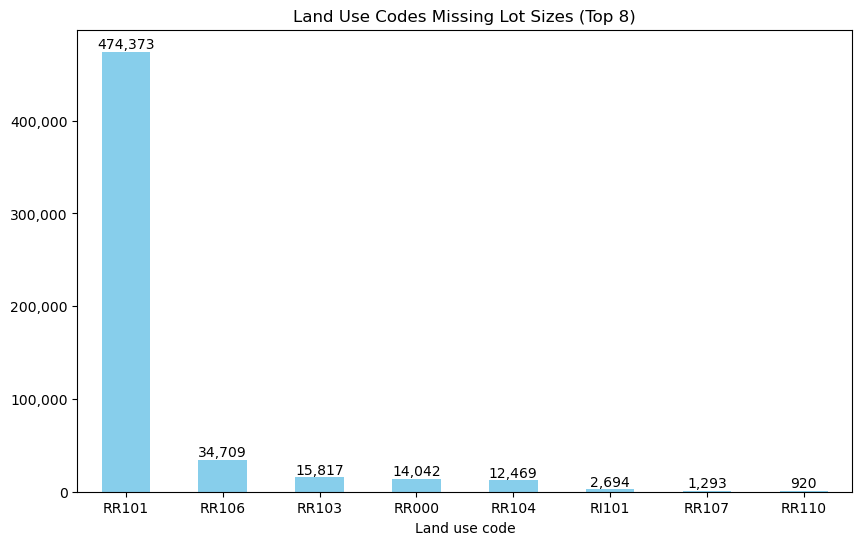

In [52]:
%matplotlib inline
import matplotlib
# count NaN values in the 'lotSize_SF' column
missingLotSize = gpd.GeoDataFrame(final_df[final_df['lotSize_SF'].isna()])
numberOfLUCs = missingLotSize['landUse_code'].nunique()
value_counts = missingLotSize['landUse_code'].value_counts()

sorted_counts = value_counts.sort_values(ascending=False).head(8)

ax = sorted_counts.plot.bar(
    figsize=(10,6), 
    rot=0,
    color='skyblue', 
    title='Land Use Codes Missing Lot Sizes (Top 8)'
    )
ax.set_xlabel('Land use code')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

print(f'total parcels missing lot size values: {missingLotSize.shape[0]:,}')
print(f'number of unique land use codes: {numberOfLUCs}')
ax.bar_label(ax.containers[0], fmt='{:,.0f}')

In [53]:
grouped_df = missingLotSize[missingLotSize['landUse_code'] == 'RR101'].groupby(
    'GEOID')['landUse_code'].count()

grouped_df = gpd.GeoDataFrame(pd.merge(
    grouped_df,
    GA_2018_Tracts,
    how='left',
    on='GEOID'
))

grouped_df.explore(
    tiles='CartoDB positron',
    column='landUse_code',
    cmap='Blues',
    style_kwds={
        'weight': 1,
        'color': '#bdbdbd',
        'fillOpacity': 0.8
    }
)

### pre-processing steps before supervised learning


In [54]:
# slim down dataframe
final_df_2 = final_df[[
    'parcel_ID',
    'GEOID',
    'geometry',
    'landUse_code'
]]

# group on the GEOID column and take a count of each land use code
groupby_df_18 = final_df_2.groupby(
    ['GEOID', 'landUse_code']).size().unstack(fill_value=0).reset_index()

# Rename the index column to an empty string
groupby_df_18.index.name = None

groupby_df_18

landUse_code        GEOID  AG000  AG101  AG102  AG109  AG121  AG199  CO000  \
0             13057090100      0      0      0      0      0      0      0   
1             13057090200      0      0      0      0      0      0      0   
2             13057090300      0      0      0      0      0      0      0   
3             13057090400      0      0      0      0      0      0      0   
4             13057090501      0      0      0      0      0      0      0   
..                    ...    ...    ...    ...    ...    ...    ...    ...   
777           13247060403      0      0      0      0      0      0      0   
778           13247060404      0      0      0      0      0      0      0   
779           13247060405      0      0      0      0      0      0      0   
780           13247060406      0      0      0      0      0      0      0   
781           13247060407      0      0      0      0      0      0      0   

landUse_code  CO101  CO105  ...  RR103  RR104  RR105  RR106  RR107  RR110  \
0                 0     18  ...    392      0      0     24      0      0   
1                 0      7  ...    337      0      0     63      0      0   
2                 0      3  ...    172    126      0      0      0      0   
3                 0     24  ...    103    154      0     84      0      0   
4                 0      9  ...    164      0      0      0      0      0   
..              ...    ...  ...    ...    ...    ...    ...    ...    ...   
777               0      0  ...     14      0      0      0      0      0   
778               0      0  ...      0      0      0      0      0      0   
779               0      0  ...      8      0      0      0      0      0   
780               0      0  ...      3      0      0      0      0      0   
781               0      0  ...      0      0      0      0      0      0   

landUse_code  RR115  RR117  RR118  RR999  
0                 0      0      0      0  
1                 0      0      0      0  
2                 0      0      0      0  
3                 0      0      0      0  
4                 0      0      0      0  
..              ...    ...    ...    ...  
777               1      0      0      0  
778               0      0      0      0  
779               0      0      0      0  
780               0      0      0      0  
781               0      0      0      0  

[782 rows x 110 columns]

In [55]:
# Define a threshold function (similar to the previous example)
def get_high_zero_columns(df, threshold):
    """
    This function returns a list of column names in a DataFrame that 
    have a percentage of values greater than or equal to the given threshold.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze.
        threshold (float): The percentage threshold for 0 values (e.g., 0.9 for 90%).

    Returns:
        list: A list of column names exceeding the threshold of 0 values.
    """
    # Calculate the percentage of 0 values in each column
    pct_zero = 1 - (df.ne(0).sum(axis=0) / len(df))

    # Filter column names based on the threshold
    return df.columns[pct_zero >= threshold].tolist()


# Get list of columns with 95% or more 0 values
high_zero_cols_95 = get_high_zero_columns(groupby_df_18, 0.95)

# filter down the grouped dataframe to exclude columns that contains 95% or more 0 values
filtered_df_18 = groupby_df_18[[
    col for col in groupby_df_18.columns if col not in high_zero_cols_95]]


# Calculate the number of 0 values in each column to check and make sure that 'filtered_df' really does
# only include columns with less than 95% 0 values
num_zeros_per_col = filtered_df_18.eq(0).sum(axis=0)
num_zeros_per_col.sort_values(ascending=False)

landUse_code
IH114    742
IH120    740
CR148    738
IN102    737
CR137    733
CR106    733
CR132    726
RI103    725
AG109    722
RR118    708
IH101    708
RI106    707
CR141    703
AG000    700
CR115    700
CR107    696
RI107    695
CR139    694
CR134    694
IN104    687
CR109    684
CO106    681
CR149    678
CR133    678
RR999    675
AG121    675
IN101    665
CR110    654
CR119    645
CR138    640
RI102    633
RR110    628
CO110    615
RR102    613
CR122    595
CR128    589
IN000    567
CR124    560
CR112    512
RR103    492
CR130    484
CR108    475
IN103    465
CO108    464
CR131    454
CO109    450
CO101    417
RR104    412
CR123    390
RI112    387
RI101    376
RR106    354
CR111    331
RR000    325
CR101    308
CO105    292
CR117    245
CR000    194
RR101      5
GEOID      0
dtype: int64

In [56]:
# read in Erik's land use classification labels (urban-suburban-rural) that were used in 2018
landUse_labels = pd.read_csv(
    'tracts_by_submarket.csv',
    dtype={
        'GEOID': 'str'
    })

# merge dataframes
merged_df_18 = pd.merge(filtered_df_18, landUse_labels,
                        how='right', on='GEOID')

# clean up the dataframe
merged_df_18 = merged_df_18.drop(columns='Submarket')

# move the classification column from the last to the second position
new_order = merged_df_18.columns.tolist()
new_order.insert(1, new_order.pop())
merged_df_18 = merged_df_18.reindex(columns=new_order)

merged_df_18 = merged_df_18.rename(columns={
    'General Landuse Type': 'label'
})

merged_df_18

GEOID  label  AG000  AG109  AG121  CO101  CO105  CO106  CO108  \
0    13067031001  Urban      0      0      0     28      3      0      0   
1    13121010603  Urban      0      0      0      1      1      0      1   
2    13067031311  Urban      0      0      0      9      2      0      0   
3    13121010604  Urban      0      0      0      1      6      1      1   
4    13121006700  Urban      0      0      1      1      0      1      1   
..           ...    ...    ...    ...    ...    ...    ...    ...    ...   
768  13117130202  Rural     11     17      0      0      0      0      0   
769  13117130503  Rural      0      5      0      0      0      0      0   
770  13117130102  Rural      9     17      0      0      0      0      0   
771  13117130101  Rural     22     23      0      0      0      0      0   
772  13117130201  Rural     19     22      0      0      0      0      0   

     CO109  ...  RI112  RR000  RR101  RR102  RR103  RR104  RR106  RR110  \
0        0  ...      0     32    825      0    349      0     35      0   
1        2  ...     13      2    365      0      0      0      0      0   
2        0  ...      0     11   1706      0    145      0    353      0   
3        0  ...      8      3    560      0      0      0      0      0   
4        0  ...      4      7   1050      0      0    127    103      0   
..     ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
768      0  ...      0     44   1422      0     37      0      0      0   
769      0  ...      0     17   1180      0     26      0     17      0   
770      0  ...      0     42    829      0     53      0      0      0   
771      0  ...      0     92   1275      0    103      0      0      0   
772      0  ...      0    133   1230      0     67      0      0      0   

     RR118  RR999  
0        0      0  
1        0      0  
2        0      0  
3        0      0  
4        0      0  
..     ...    ...  
768      0      0  
769      0      0  
770      0      0  
771      0      0  
772      0      0  

[773 rows x 61 columns]

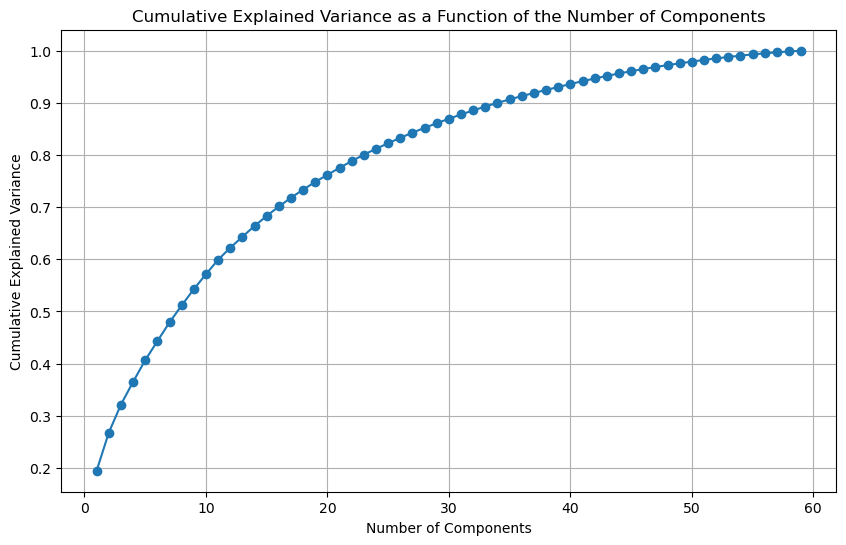

In [57]:
# Separate the features and labels
X = merged_df_18.drop(columns=['GEOID', 'label'])
y = merged_df_18['label']

# Standardize the features
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Plot the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.grid(True)
plt.show()

In [71]:
# Based on the chart above, we see that 40 components (i.e., land use categories) are needed to explain 80% of the variance
pca = PCA(n_components=22)
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame with the PCA components
pca_df = pd.DataFrame(
    X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['label'] = y.values

pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.378422  0.158242  0.242309  0.176087 -0.050649  0.507131 -0.575460   
1    0.202013  0.141025  0.056598 -0.028965  0.091348 -0.012994 -0.031795   
2    0.232093 -0.050083  0.014154 -0.089838 -0.293251  0.029611 -0.232283   
3    0.062746  0.001701 -0.102709  0.246532  0.029544 -0.036409  0.147109   
4   -0.102296  0.053941  0.000209 -0.128991  0.084944  0.250261  0.181323   
..        ...       ...       ...       ...       ...       ...       ...   
768 -0.340842 -0.050159  0.017905  0.003729  0.003513 -0.031737 -0.043937   
769 -0.334907 -0.032075 -0.002556 -0.000137  0.015358 -0.010223 -0.039756   
770 -0.347076 -0.031368 -0.000135  0.002979  0.015129 -0.012651 -0.051589   
771 -0.345753 -0.054523  0.025642  0.006288 -0.001143 -0.035241 -0.053763   
772 -0.346904 -0.047163  0.018188  0.009908 -0.003320 -0.039230 -0.047132   

          PC8       PC9      PC10  ...      PC14      PC15      PC16  \
0   -0.382141 -0.093148  0.006902  ...  0.090301  0.024968  0.076645   
1   -0.090058  0.178109  0.277954  ... -0.004093 -0.107722  0.065086   
2   -0.348280 -0.046106  0.059048  ...  0.107162  0.135505  0.003444   
3   -0.113259 -0.092936  0.073932  ...  0.019862 -0.002961  0.147624   
4   -0.093147 -0.042311 -0.028349  ... -0.048029 -0.040243  0.033487   
..        ...       ...       ...  ...       ...       ...       ...   
768  0.028197  0.033755 -0.025483  ... -0.041037 -0.029558  0.019798   
769  0.014008  0.045470 -0.018081  ...  0.003711 -0.017871  0.008504   
770  0.020293  0.069106 -0.028538  ... -0.023707 -0.053236  0.044347   
771  0.032601  0.041636 -0.034394  ... -0.072064 -0.050565  0.045785   
772  0.030969  0.038966 -0.039941  ... -0.067439 -0.044576  0.049221   

         PC17      PC18      PC19      PC20      PC21      PC22  label  
0   -0.230422  0.130928  0.208747 -0.354801 -0.000612  0.105238  Urban  
1   -0.081922 -0.005716 -0.029999 -0.123983 -0.137157 -0.066146  Urban  
2    0.054988  0.007573 -0.078494  0.065315  0.066032 -0.037882  Urban  
3   -0.008402 -0.114625  0.078518  0.002490 -0.080813 -0.015713  Urban  
4    0.014088  0.021152 -0.045387 -0.111463 -0.096371  0.079227  Urban  
..        ...       ...       ...       ...       ...       ...    ...  
768 -0.014171  0.049003  0.028694 -0.056215 -0.005925 -0.051560  Rural  
769 -0.022803  0.019931  0.023449 -0.006248 -0.018256 -0.016520  Rural  
770  0.005503  0.016235  0.045641 -0.053235 -0.002917 -0.053525  Rural  
771 -0.010869  0.046317  0.041011 -0.096796  0.015728 -0.087188  Rural  
772 -0.008685  0.053298  0.022501 -0.102854  0.009052 -0.071450  Rural  

[773 rows x 23 columns]

In [74]:
# Step 3: split the dataset into training (80%) and test (20%) sets
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    pca_df.drop(columns=['label']),
    pca_df['label'],
    test_size=0.2,
    random_state=42
)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Evaluate scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

              precision    recall  f1-score   support

       Rural       0.50      0.07      0.12        14
    Suburban       0.74      0.90      0.81        89
       Urban       0.80      0.69      0.74        52

    accuracy                           0.75       155
   macro avg       0.68      0.55      0.56       155
weighted avg       0.74      0.75      0.73       155

Accuracy: 0.7548387096774194
Cross-validation scores: [0.81451613 0.78225806 0.7983871  0.72357724 0.80487805]
Average cross-validation score: 0.7847233149750853


### prepare 2023 Ztrax data


In [61]:
# read in data
building_df_23 = pd.read_csv(
    '../../8_AltData/2023_Ztrax/Building.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    3: 'landUse_desc',
    5: 'landUse_code',
    8: 'building_no',
    45: 'FIPS'
}

# Rename and select the relevant columns fromt the above dictionary
building_df_23 = building_df_23.rename(columns=rename_dict)[
    list(rename_dict.values())]

# cast FIPS as string
building_df_23['FIPS'] = building_df_23['FIPS'].astype(str)

# define list of metro ATL counties
atl_FIPS = {
    'CHEROKEE': '13057',
    'CLAYTON': '13063',
    'COBB': '13067',
    'DEKALB': '13089',
    'DOUGLAS': '13097',
    'FAYETTE': '13113',
    'FORSYTH': '13117',
    'FULTON': '13121',
    'GWINNETT': '13135',
    'HENRY': '13151',
    'ROCKDALE': '13247'
}
building_df_23 = building_df_23[building_df_23['FIPS'].isin(atl_FIPS.values())]

# create a building ID field
building_df_23['building_ID'] = building_df_23['parcel_ID'] + \
    '-' + building_df_23['building_no'].astype(str)

print(f'Total rows: {building_df_23.shape[0]:,}')
print(f'Unique parcels: {building_df_23["parcel_ID"].nunique():,}')
print(
    f'Parcels with multiple buildings: {building_df_23.shape[0]-building_df_23["parcel_ID"].nunique():,}')
building_df_23.head(5)

Total rows: 1,766,087
Unique parcels: 1,715,947
Parcels with multiple buildings: 50,140


parcel_ID  landUse_desc landUse_code  \
552183  A9BA3002-0000-0000-3301-000000000000   SFR (Rural)        RR102   
552184  A9BA3002-0000-0000-3301-000000000000   SFR (Rural)        RR102   
552185  AABA3002-0000-0000-3301-000000000000  Mobile Homes        RR103   
552186  ABBA3002-0000-0000-3301-000000000000   SFR (Rural)        RR102   
552187  ACBA3002-0000-0000-3301-000000000000   SFR (Rural)        RR102   

        building_no   FIPS                             building_ID  
552183            1  13057  A9BA3002-0000-0000-3301-000000000000-1  
552184            2  13057  A9BA3002-0000-0000-3301-000000000000-2  
552185            1  13057  AABA3002-0000-0000-3301-000000000000-1  
552186            1  13057  ABBA3002-0000-0000-3301-000000000000-1  
552187            1  13057  ACBA3002-0000-0000-3301-000000000000-1

In [62]:
# read in data
buildingAreas_df_23 = pd.read_csv(
    '../../8_AltData/2023_Ztrax/BuildingAreas.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    1: 'building_no',
    2: 'bldgAreaSequence_no',
    3: 'bldgArea_code',
    4: 'bldg_SF',
    5: 'FIPS'
}

# Rename and select the relevant columns fromt the above dictionary
buildingAreas_df_23 = buildingAreas_df_23.rename(columns=rename_dict)[
    list(rename_dict.values())]

# just get ATL counties
buildingAreas_df_23 = buildingAreas_df_23[buildingAreas_df_23['FIPS'].astype(
    str).isin(atl_FIPS.values())]

# Remove rows with NaN values in the relevant columns
buildingAreas_df_23 = buildingAreas_df_23.dropna(
    subset=['parcel_ID', 'building_no', 'bldg_SF'])

# This will take the max square footage for buildings where multiple SFs are reported
idx = buildingAreas_df_23.groupby(['parcel_ID', 'building_no'])[
    'bldg_SF'].idxmax()

# Select the rows corresponding to these indices
result_df = buildingAreas_df_23.loc[idx].reset_index(drop=True)

# create building_ID field to match with Building.txt
result_df['building_ID'] = result_df['parcel_ID'] + \
    '-' + result_df['building_no'].astype(str)

print(f'total rows: {result_df.shape[0]:,}')

# join Building.txt with BuildingArea.txt to get square footages for each building
building_joined = pd.merge(
    building_df_23,
    result_df,
    on='building_ID',
    how='left'
)

building_joined = building_joined[[
    'parcel_ID_x',
    'landUse_code',
    'bldg_SF',
]]

building_joined = building_joined.rename(columns={
    'parcel_ID_x': 'parcel_ID',
})

print(f'rows: {building_joined.shape[0]:,}')
building_joined.head()

total rows: 1,566,251
rows: 1,766,087


parcel_ID landUse_code  bldg_SF
0  A9BA3002-0000-0000-3301-000000000000        RR102   2164.0
1  A9BA3002-0000-0000-3301-000000000000        RR102   1104.0
2  AABA3002-0000-0000-3301-000000000000        RR103   1740.0
3  ABBA3002-0000-0000-3301-000000000000        RR102   1674.0
4  ACBA3002-0000-0000-3301-000000000000        RR102   1613.0

In [63]:
# Step 1: Identify duplicates in 'parcel_ID'
duplicate_parcels = building_joined[building_joined.duplicated(
    'parcel_ID', keep=False)]


# Step 2: Filter groups with different 'landUse_code' values
def has_different_landUse_code(group):
    return group['landUse_code'].nunique() > 1


different_land_use_groups = duplicate_parcels.groupby(
    'parcel_ID').filter(has_different_landUse_code)

# Step 3: Get indices of rows to drop
indices_to_drop = different_land_use_groups.index

# Step 4: Drop those rows from the original DataFrame
building_cleaned_1 = building_joined.drop(indices_to_drop)

different_land_use_groups_withoutNA = different_land_use_groups.dropna(
    subset='bldg_SF')
idx_max_bldg_SF = different_land_use_groups_withoutNA.groupby('parcel_ID')[
    'bldg_SF'].idxmax()

selected_rows = different_land_use_groups_withoutNA.loc[idx_max_bldg_SF]

new_df = pd.concat([building_cleaned_1, selected_rows])

print(f'rows: {new_df.shape[0]:,}')
print(f'unique parcel_ID values: {new_df["parcel_ID"].nunique():,}')
new_df.head(10)

rows: 1,762,179
unique parcel_ID values: 1,715,942


parcel_ID landUse_code  bldg_SF
0   A9BA3002-0000-0000-3301-000000000000        RR102   2164.0
1   A9BA3002-0000-0000-3301-000000000000        RR102   1104.0
2   AABA3002-0000-0000-3301-000000000000        RR103   1740.0
3   ABBA3002-0000-0000-3301-000000000000        RR102   1674.0
4   ACBA3002-0000-0000-3301-000000000000        RR102   1613.0
5   ADBA3002-0000-0000-3301-000000000000        RR102   2442.0
6   AEBA3002-0000-0000-3301-000000000000        RR102   3342.0
7   AEBA3002-0000-0000-3301-000000000000        RR102    664.0
17  B1BA3002-0000-0000-3301-000000000000        RR102   1673.0
18  B3BA3002-0000-0000-3301-000000000000        RR102   2078.0

In [64]:
# read in data
main_df = pd.read_csv(
    '../../8_AltData/2023_Ztrax/Main.txt',
    sep='|',
    low_memory=False,
    header=None
)

# define rename dictionary
rename_dict = {
    0: 'parcel_ID',
    2: 'FIPS',
    69: 'lotSize_acres',
    70: 'lotSize_SF',
    81: 'lat',
    82: 'long'
}

# Rename and select the relevant columns fromt the above dictionary
main_df = main_df.rename(columns=rename_dict)[list(rename_dict.values())]

# cast FIPS as string
main_df['FIPS'] = main_df['FIPS'].astype('str')

# filter to select only metro counties
main_df = main_df[main_df['FIPS'].isin(atl_FIPS.values())]

print(f'rows: {main_df.shape[0]:,}')
print(f'missing lat values: {main_df["lat"].isna().sum():,}')
print(f'missing long values: {main_df["long"].isna().sum():,}')
main_df.head(10)

rows: 1,715,947
missing lat values: 242,062
missing long values: 242,062


parcel_ID   FIPS  lotSize_acres  \
651305  A9BA3002-0000-0000-3301-000000000000  13057          32.30   
651306  AABA3002-0000-0000-3301-000000000000  13057           2.00   
651307  ABBA3002-0000-0000-3301-000000000000  13057         102.49   
651308  ACBA3002-0000-0000-3301-000000000000  13057           2.76   
651309  ADBA3002-0000-0000-3301-000000000000  13057          29.61   
651310  AEBA3002-0000-0000-3301-000000000000  13057           2.33   
651311  AFBA3002-0000-0000-3301-000000000000  13057          35.57   
651312  B0BA3002-0000-0000-3301-000000000000  13057           4.00   
651313  B1BA3002-0000-0000-3301-000000000000  13057           2.00   
651314  B3BA3002-0000-0000-3301-000000000000  13057           1.32   

        lotSize_SF        lat       long  
651305   1406988.0  34.184051 -84.413712  
651306     87120.0  34.184860 -84.410827  
651307   4464464.4  34.190442 -84.413311  
651308    120225.6        NaN        NaN  
651309   1289811.6        NaN        NaN  
651310    101494.8        NaN        NaN  
651311   1549429.2  34.205098 -84.416169  
651312    174240.0        NaN        NaN  
651313     87120.0  34.204066 -84.412183  
651314     57499.2        NaN        NaN

In [65]:
# convert main_df to GeoDataFrame
main_df_geo = gpd.GeoDataFrame(
    main_df,
    geometry=gpd.points_from_xy(main_df['long'], main_df['lat']),
    crs="EPSG:4269"
)

# read in and clean the 2020 vintage of GA Census tracts
GA_2020_Tracts = gpd.read_file('../ARC_CTs.gpkg')
GA_2020_Tracts['FIPS'] = GA_2020_Tracts['STATEFP'].astype(
    'str') + GA_2020_Tracts['COUNTYFP'].astype('str')
GA_2020_Tracts = GA_2020_Tracts[[
    'FIPS',
    'GEOID',
    'geometry'
]]

# filter down to metro ATL
GA_2020_Tracts = GA_2020_Tracts[GA_2020_Tracts['FIPS'].isin(atl_FIPS.values())]

# spatially join the main.txt file to the 2018 tract file
main_df_joined = main_df_geo.sjoin(GA_2020_Tracts, predicate='within')

# clean up the resulting dataframe
main_df_joined = main_df_joined.drop(
    columns=['FIPS_right', 'index_right']).rename(columns={'FIPS_left': 'FIPS'})

print(f'rows: {main_df_joined.shape[0]:,}')
main_df_joined.head()

rows: 1,473,358


parcel_ID   FIPS  lotSize_acres  \
651305  A9BA3002-0000-0000-3301-000000000000  13057          32.30   
651306  AABA3002-0000-0000-3301-000000000000  13057           2.00   
651307  ABBA3002-0000-0000-3301-000000000000  13057         102.49   
651317  B6BA3002-0000-0000-3301-000000000000  13057           2.00   
651319  B8BA3002-0000-0000-3301-000000000000  13057          14.00   

        lotSize_SF        lat       long                    geometry  \
651305   1406988.0  34.184051 -84.413712  POINT (-84.41371 34.18405)   
651306     87120.0  34.184860 -84.410827  POINT (-84.41083 34.18486)   
651307   4464464.4  34.190442 -84.413311  POINT (-84.41331 34.19044)   
651317     87120.0  34.186210 -84.413279  POINT (-84.41328 34.18621)   
651319    609840.0  34.185737 -84.408092  POINT (-84.40809 34.18574)   

              GEOID  
651305  13057090810  
651306  13057090810  
651307  13057090810  
651317  13057090810  
651319  13057090810

In [66]:
# join the main & building files
merged_df = pd.merge(
    main_df_joined,
    new_df,
    how='left',
    on='parcel_ID'
)

# clean up the merged dataframe
merged_df = merged_df.drop(columns=[
    'FIPS',
    # 'lat',
    # 'long',
    # 'geometry',
    'bldg_SF']
).rename(columns={'FIPS_x': 'FIPS'})

# drop any NaNs from the 'landUse_code' column
noNaNs_df = merged_df.dropna(subset='landUse_code')

print(f'Total rows: {merged_df.shape[0]:,}')
print(
    f'Total rows with null values from landUse_code removed: {noNaNs_df.shape[0]:,}')
merged_df.head(10)

Total rows: 1,515,673
Total rows with null values from landUse_code removed: 1,515,668


parcel_ID  lotSize_acres  lotSize_SF        lat  \
0  A9BA3002-0000-0000-3301-000000000000          32.30   1406988.0  34.184051   
1  A9BA3002-0000-0000-3301-000000000000          32.30   1406988.0  34.184051   
2  AABA3002-0000-0000-3301-000000000000           2.00     87120.0  34.184860   
3  ABBA3002-0000-0000-3301-000000000000         102.49   4464464.4  34.190442   
4  B6BA3002-0000-0000-3301-000000000000           2.00     87120.0  34.186210   
5  B8BA3002-0000-0000-3301-000000000000          14.00    609840.0  34.185737   
6  B9BA3002-0000-0000-3301-000000000000           2.00     87120.0  34.187141   
7  BCBA3002-0000-0000-3301-000000000000           1.44     62726.4  34.186898   
8  BDBA3002-0000-0000-3301-000000000000          62.19   2708996.4  34.191908   
9  BDBA3002-0000-0000-3301-000000000000          62.19   2708996.4  34.191908   

        long                    geometry        GEOID landUse_code  
0 -84.413712  POINT (-84.41371 34.18405)  13057090810        RR102  
1 -84.413712  POINT (-84.41371 34.18405)  13057090810        RR102  
2 -84.410827  POINT (-84.41083 34.18486)  13057090810        RR103  
3 -84.413311  POINT (-84.41331 34.19044)  13057090810        RR102  
4 -84.413279  POINT (-84.41328 34.18621)  13057090810        RR102  
5 -84.408092  POINT (-84.40809 34.18574)  13057090810        RR102  
6 -84.407274  POINT (-84.40727 34.18714)  13057090810        RR103  
7 -84.409313  POINT (-84.40931 34.18690)  13057090810        RR102  
8 -84.409925  POINT (-84.40993 34.19191)  13057090810        VL104  
9 -84.409925  POINT (-84.40993 34.19191)  13057090810        VL104

In [67]:
noNaNs_df = noNaNs_df[~noNaNs_df['landUse_code'].isin(LUcodes_ToExclude)]

# Step 1: Create a boolean mask for each string in the list
masks = [~noNaNs_df['landUse_code'].str.startswith(
    prefix) for prefix in Classifications_ToExclude]

# Step 2: Combine the masks
final_mask = masks[0]
for mask in masks[1:]:
    final_mask &= mask

# Step 3: Filter the DataFrame using the final mask
final_df = noNaNs_df[final_mask]

print(f'total rows: {final_df.shape[0]:,}')
final_df.head(7)

total rows: 1,428,213


parcel_ID  lotSize_acres  lotSize_SF        lat  \
0  A9BA3002-0000-0000-3301-000000000000          32.30   1406988.0  34.184051   
1  A9BA3002-0000-0000-3301-000000000000          32.30   1406988.0  34.184051   
2  AABA3002-0000-0000-3301-000000000000           2.00     87120.0  34.184860   
3  ABBA3002-0000-0000-3301-000000000000         102.49   4464464.4  34.190442   
4  B6BA3002-0000-0000-3301-000000000000           2.00     87120.0  34.186210   
5  B8BA3002-0000-0000-3301-000000000000          14.00    609840.0  34.185737   
6  B9BA3002-0000-0000-3301-000000000000           2.00     87120.0  34.187141   

        long                    geometry        GEOID landUse_code  
0 -84.413712  POINT (-84.41371 34.18405)  13057090810        RR102  
1 -84.413712  POINT (-84.41371 34.18405)  13057090810        RR102  
2 -84.410827  POINT (-84.41083 34.18486)  13057090810        RR103  
3 -84.413311  POINT (-84.41331 34.19044)  13057090810        RR102  
4 -84.413279  POINT (-84.41328 34.18621)  13057090810        RR102  
5 -84.408092  POINT (-84.40809 34.18574)  13057090810        RR102  
6 -84.407274  POINT (-84.40727 34.18714)  13057090810        RR103

In [68]:
# slim down dataframe
final_df_2 = final_df[[
    'parcel_ID',
    'GEOID',
    'geometry',
    'landUse_code'
]]

# group on the GEOID column and take a count of each land use code
groupby_df = final_df_2.groupby(
    ['GEOID', 'landUse_code']).size().unstack(fill_value=0).reset_index()

# Rename the index column to an empty string
groupby_df.index.name = None

# Get list of columns with 95% or more 0 values
high_zero_cols_95 = get_high_zero_columns(groupby_df, 0.95)

# filter down the grouped dataframe to exclude columns that contains 95% or more 0 values
filtered_df = groupby_df[[
    col for col in groupby_df.columns if col not in high_zero_cols_95]]


# Calculate the number of 0 values in each column to check and make sure that 'filtered_df' really does
# only include columns with less than 95% 0 values
num_zeros_per_col = filtered_df.eq(0).sum(axis=0)
num_zeros_per_col.sort_values(ascending=False)

landUse_code
CR115    1180
CR149    1179
CR132    1176
CR134    1173
AG000    1170
CR141    1169
IH101    1150
CO106    1145
CR122    1142
CR109    1139
CR133    1136
RR999    1134
CR128    1131
RR105    1127
CR107    1127
AG121    1109
RR118    1108
IN104    1107
CR110    1103
CR119    1099
RI107    1087
CR124    1087
RI102    1087
CR138    1085
RR000    1070
CO000    1063
CO110    1060
IN000    1053
RR110    1016
RR102     985
IN103     962
CR112     959
CR130     955
CO109     940
RI106     915
RR103     912
CO101     860
CR123     852
CR108     840
CO108     833
CR131     821
RI112     808
CO105     798
CR111     751
RI101     729
CR000     707
CR101     663
RR106     661
RR104     640
CR117     628
RR101      25
GEOID       0
dtype: int64